# Deep Deterministic Policy Gradient (DDPG)


#### Connect to drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
os.chdir('/content/drive/My Drive/RL/code/')

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/RL/code/')

### Install and import the libraries

In [ ]:
!pip install box2d-py

     |████████████████████████████████| 450kB 9.9MB/s 


In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install gym
!pip install 'imageio==2.4.0'
!pip install matplotlib
!pip install PILLOW
!pip install tf-agents[reverb]
!pip install pybullet

!apt-get install -y xvfb x11-utils
!apt install python-opengl
!pip3 install pyvirtualdisplay
!pip3 install box2d-py
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

In [ ]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

### Prepare the environment

In [ ]:
problem = "BipedalWalker-v3"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  24
Size of Action Space ->  4
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Build the agent

In [ ]:

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


In [ ]:

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


In [ ]:

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(512, activation="relu")(out)
    out = layers.Dropout(rate= 0.2)(out)
    out = layers.Dense(512, activation="relu")(out)
    out = layers.Dense(256, activation="relu")(out)
    out = layers.Dropout(rate= 0.2)(out)
    out = layers.Dense(128, activation="relu")(out)
    out = layers.Dropout(rate= 0.2)(out)
    out = layers.Dense(64, activation="relu")(out)
    out = layers.Dense(16, activation="relu")(out)
    outputs = layers.Dense(4, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)

    out = layers.Dense(512, activation="relu")(out)
    out = layers.Dropout(rate= 0.2)(out)
    out = layers.Dense(512, activation="relu")(out)
    out = layers.Dense(256, activation="relu")(out)
    out = layers.Dropout(rate= 0.2)(out)
    out = layers.Dense(128, activation="relu")(out)
    out = layers.Dropout(rate= 0.2)(out)
    out = layers.Dense(64, activation="relu")(out)
    out = layers.Dense(16, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


`policy()` returns an action sampled from our Actor network plus some noise for
exploration.

In [ ]:

def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))

    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.squeeze(legal_action)


## Training hyperparameters

In [ ]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.0002
actor_lr = 0.0002

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000000
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(1000000, 64)

In [ ]:
# Save the weights
actor_model.load_weights("./ddpg_results/pendulum_actor.h5")
critic_model.load_weights("./ddpg_results/pendulum_critic.h5")

target_actor.load_weights("./ddpg_results/pendulum_target_actor.h5")
target_critic.load_weights("./ddpg_results/pendulum_target_critic.h5")

Now we implement our main training loop, and iterate over episodes.
We sample actions using `policy()` and train with `learn()` at each time step,
along with updating the Target networks at a rate `tau`.

In [ ]:
total_num_steps = 200000

In [ ]:


# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
avg_ep_reward_list = []
total_step_counter = 0
all_rewards_steps_list = []
avg_rewards_steps_list = []
step_num_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0
    
    if total_step_counter >= total_num_steps:
            break

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()
        total_step_counter += 1

        if total_step_counter >= total_num_steps:
            break

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)


        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward
        # all_rewards_steps_list.append(reward)

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 20 episodes
    avg_reward = np.mean(ep_reward_list[-20:])
    avg_ep_reward_list.append(avg_reward)
    # avg_rewards_steps = np.mean(all_rewards_steps_list[-20:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    # print("Step * {} * Avg Reward is ==> {}".format(total_step_counter, avg_rewards_steps))
    # avg_reward_list.append(avg_reward)
    # avg_rewards_steps_list.append(avg_rewards_steps)
    step_num_list.append(total_step_counter)

    

Episode * 0 * Avg Reward is ==> -100.47471636672248
Episode * 1 * Avg Reward is ==> -100.53793697728275
Episode * 2 * Avg Reward is ==> -119.30074975374343
Episode * 3 * Avg Reward is ==> -127.16858477836817
Episode * 4 * Avg Reward is ==> -123.95061787913028
Episode * 5 * Avg Reward is ==> -121.9369852212396
Episode * 6 * Avg Reward is ==> -121.39251511643705
Episode * 7 * Avg Reward is ==> -120.76031591620708
Episode * 8 * Avg Reward is ==> -120.45058581580416
Episode * 9 * Avg Reward is ==> -119.58815981274806
Episode * 10 * Avg Reward is ==> -118.95743878347497
Episode * 11 * Avg Reward is ==> -118.19491267140705
Episode * 12 * Avg Reward is ==> -117.58182249574783
Episode * 13 * Avg Reward is ==> -116.9526753329487
Episode * 14 * Avg Reward is ==> -116.6899450890638
Episode * 15 * Avg Reward is ==> -119.45861203112777
Episode * 16 * Avg Reward is ==> -120.99977659665579
Episode * 17 * Avg Reward is ==> -123.25274393663375
Episode * 18 * Avg Reward is ==> -125.27768263143231
Episod

In [ ]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
RUN_NUM = 1

In [ ]:
print(len(step_num_list))
print(len(avg_ep_reward_list))

425
425


In [ ]:
np.save(file = f'./ddpg_results/avg_ep_reward_list_run{RUN_NUM}.npy' , arr = avg_ep_reward_list)
np.save(file = f'./ddpg_results/step_num_list_run{RUN_NUM}.npy' , arr = step_num_list)

### Plot the results

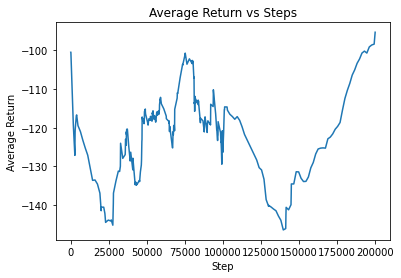

In [ ]:
# Plotting graph
# Steps versus Avg. Return
plt.plot(step_num_list, avg_ep_reward_list)
plt.xlabel("Step")
plt.ylabel("Average Return")
plt.title('Average Return vs Steps')
plt.savefig(f'./ddpg_results/avg_return_steps_run{RUN_NUM}.png')
plt.show()

In [ ]:
# Save the weights
actor_model.save_weights("./ddpg_results/pendulum_actor.h5")
critic_model.save_weights("./ddpg_results/pendulum_critic.h5")

target_actor.save_weights("./ddpg_results/pendulum_target_actor.h5")
target_critic.save_weights("./ddpg_results/pendulum_target_critic.h5")

### Simulate the Bipedal Walker using the learned policy

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
eval_env = gym.make('BipedalWalker-v3')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import os
import tempfile
import PIL.Image
from IPython import display

In [ ]:
num_episodes = 3
video_filename = 'ddpg_bipedal_walker.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    prev_state = eval_env.reset()
    # img = plt.imshow(eval_env.render(mode='rgb_array'))
    video.append_data(eval_env.render(mode='rgb_array'))
    while True :
      tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
      action = policy(tf_prev_state, ou_noise)

      # Recieve state and reward from environment.
      state, reward, done, info = eval_env.step(action)

      # img.set_data(eval_env.render(mode='rgb_array')) 
      # plt.axis('off')
      # display.display(plt.gcf())
      # display.clear_output(wait=True)

      video.append_data(eval_env.render(mode='rgb_array'))

      prev_state = state
      if done == True:
          break

embed_mp4(video_filename)